<a href="https://colab.research.google.com/github/mjvakili/MLcourse/blob/master/day2/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_v2_behavior()
#matplotlib plotting settings
import matplotlib
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.major.size'] = 7
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = [7,7]

One of the criteria for success of the deep neural networks is their ability to 
generelize to examples that they have not seen before. A very complex Neural Network trained on a limited number of examples has the potential to memorize the training set and as a result it may not generalize well to unseen examples. In that case, the network is overfitting the training set.

In this exercise, we train a network on a set of noisy examples. The exmaples are noisy in that there is no clean separation between the examples in the training set. Then we will examine the decision boundaries as predicted by the network. Let's start by generating a synthetic dataset.

In [0]:
#Fix the random seed for reproducability
np.random.seed(1234)
#Generate a set of features
X = np.concatenate([np.random.randn(40, 2) + np.array([3, 3]), 
             np.random.randn(40, 2) + np.array([-3, -3]), 
             np.random.randn(40, 2) + np.array([-3, 3]), 
             np.random.randn(40, 2) + np.array([3, -3]),])
#Generate the labels
Y = np.concatenate([np.zeros((80)), np.ones((80))])

#retreive indices with label zero
zero_mask = np.where(Y == 0)[0]
#pick a random subsample of instances with label zero
random_zero_subsample = np.random.choice(zero_mask, int(0.1 * len(zero_mask)), replace = False)

#retreive indices with label zero
one_mask = np.where(Y == 1)[0]
#pick a random subsample of instances with label zero
random_one_subsample = np.random.choice(one_mask, int(0.1 * len(one_mask)), replace = False)

#Make the labels a bit noisy
Y[random_zero_subsample] = 1
Y[random_one_subsample] = 0

Text(0, 0.5, '$X_2$')

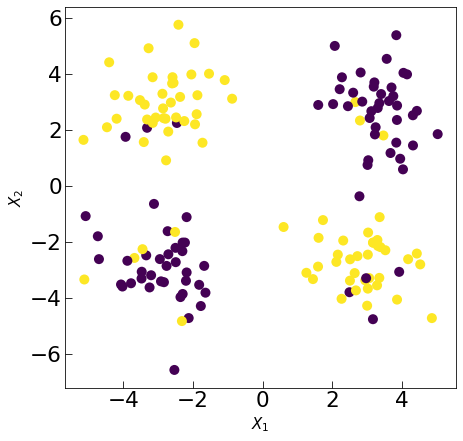

In [3]:
plt.scatter(X[:,0], X[:,1], c = Y, s = 100, edgecolor='none', alpha=1)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")

Now Let's our fiducial fully connected Neural Network with three hidden layers, including one output layer with a sigmoid activation function meant for binary classification.

In [4]:
#Dense layer
Dense = tf.keras.layers.Dense
fiducial_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(64, activation = 'relu'),
     Dense(64, activation = 'relu'),
     Dense(1, activation = 'sigmoid')])
fiducial_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


Now we fit the fiducial network to the data with and Adam optimizer and a binary cross entropy loss function.

In [5]:
fiducial_model.compile(optimizer="adam", loss="binary_crossentropy")
fiducial_model.fit(X, Y, epochs=300, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now we vizualize the decision boundaries as predicted by our fiducial Neural Network 

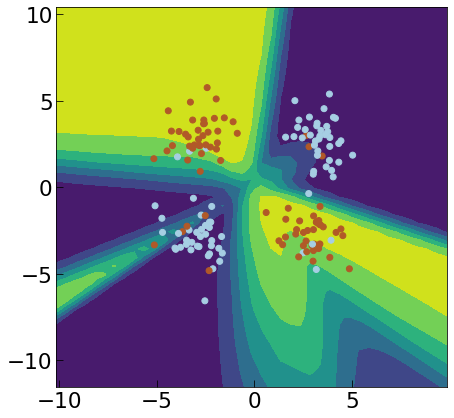

In [6]:
#Defining a grid
h = 0.5
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
#Test set
X_test = np.c_[xx.ravel(), yy.ravel()]
#Prediction of the fiducial model
fid_pred = fiducial_model.predict(X_test) 

#reshape the prediction
fid_pred = fid_pred.reshape(xx.shape)

#plotting the result
plt.contourf(xx, yy, fid_pred)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

As we can see, the decsion boundaries are affected by the outliers and so they are noisy. 

In what follows, we modify the model by adding a DropOut layer after each of the first two hidden layers. The dropout rate we adopt is 0.5. That is, during each batch update, 50% of the instances in the batch are dropped out of the batch update procedure. The dropout has the advantage of elliminating the noise in the neurons in each layer.

In [7]:
#Dense layer
Dense = tf.keras.layers.Dense
#Dropout layer
Dropout = tf.keras.layers.Dropout
modified_model = tf.keras.Sequential(
    [tf.keras.Input(shape=(2,)),
     Dense(64, activation = 'relu'),
     Dropout(0.5),
     Dense(64, activation = 'relu'),
     Dropout(0.5),
     Dense(1, activation = 'sigmoid')])
modified_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [8]:
modified_model.compile(optimizer="adam", loss="binary_crossentropy")
modified_model.fit(X, Y, epochs=300, verbose=0)

Now let's take a look at the decision boundaries predicted by the Neural network model modified with the two dropout layers.

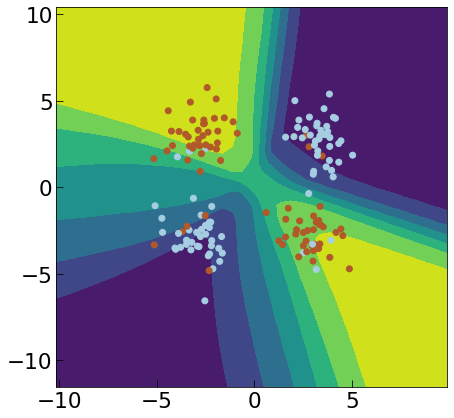

In [9]:
#model predictions
mod_pred = modified_model.predict(np.c_[xx.ravel(), yy.ravel()]) 
#reshaping the model predictions
mod_pred = mod_pred.reshape(xx.shape)
plt.contourf(xx, yy, mod_pred)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

As evident from our findings, the Neural network modified with the Dropout layer are less susceptible to the noisy labels in the data and the decision boundaries are smooth. 